<div align="right"><i>Бронников Егор</i></p>

# Лабораторная работа №1

## Импорты

In [65]:
from enum import Enum
from random import randint, choice, choices
from typing import Callable, Any, Self
from collections import defaultdict
from sys import settrace, maxsize
from types import FrameType
from inspect import getsourcelines, getmodule, getmembers, isfunction
from math import pow
from ast import NodeVisitor, FunctionDef, Call, Name, Attribute, parse
from abc import ABC, abstractmethod
from statistics import mean

from tqdm.notebook import tqdm

from maze import maze

In [2]:
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
import networkx as nx

## Base

In [4]:
class SolutionStatus(Enum):
    VALID = "VALID"
    INVALID = "INVALID"
    SOLVED = "SOLVED"

In [5]:
def get_solution_status(solution: str) -> SolutionStatus:
    return SolutionStatus(solution.split()[0])

In [6]:
get_solution_status(maze("DDDDRRRRUULLUURRRRDDDD"))

<SolutionStatus.SOLVED: 'SOLVED'>

In [7]:
def add_bar_labels(x: list[int], y: list[int], *, padding: int) -> None:
    for index in range(len(x)):
        plt.text(index, y[index] + padding, y[index], ha="center")

## Blackbox

In [8]:
class BlackBoxFuzzer:
    def __init__(
        self: Self,
        *,
        function: Callable[..., Any],
        initials: str,
        min_length: int,
        max_length: int,
        tries: int,
    ) -> None:
        self.function = function
        self.initials = initials
        self.min_length = min_length
        self.max_length = max_length
        self.tries = tries

        self.stats = defaultdict(lambda: 0)

    def run(self: Self) -> SolutionStatus:
        solution = "".join(choice(self.initials) for _ in range(randint(self.min_length, self.max_length)))
        solution_status = get_solution_status(self.function(solution))
        return solution_status

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            solution_status = self.run()
            self.stats[solution_status] += 1

__Расчёты__

In [9]:
black_box_fuzzer = BlackBoxFuzzer(
                        function=maze,
                        initials="DULR",
                        min_length=2,
                        max_length=30,
                        tries=1_000_000,
                    )

In [10]:
black_box_fuzzer.fuzz()

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [11]:
black_box_fuzzer.stats

defaultdict(<function __main__.BlackBoxFuzzer.__init__.<locals>.<lambda>()>,
            {<SolutionStatus.INVALID: 'INVALID'>: 992568,
             <SolutionStatus.VALID: 'VALID'>: 7432})

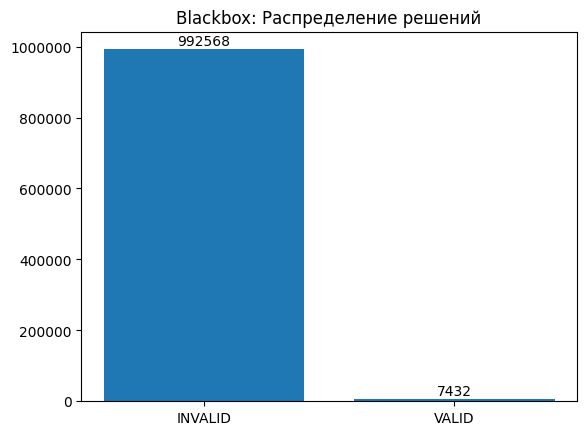

In [12]:
x = list(map(lambda status: status.value, black_box_fuzzer.stats.keys()))
y = list(black_box_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Blackbox: Распределение решений")
add_bar_labels(x, y, padding=10_000)

plt.bar(x, y)
plt.show()

## Simple Greybox: Naive Mutation Coverage

`Tracer` – класс для отслеживания выполнения программы

In [13]:
class Tracer:
    def __init__(self: Self) -> None:
        self.called_functions = set()
        self.executed_lines = set()

    def reset(self: Self) -> None:
        self.called_functions.clear()
        self.executed_lines.clear()

    def trace_lines(self: Self, frame: FrameType, event: str, arg: Any) -> None:
        if event != "line":
            return
        self.executed_lines.add(frame.f_lineno)

    def trace_calls(self: Self, frame: FrameType, event: str, arg: Any) -> FrameType | None:
        if event != "call":
            return
        func_name = frame.f_code.co_name
        self.called_functions.add(func_name)
        return self.trace_lines
    
    def trace(self: Self, function: Callable[..., Any], *args, **kwargs) -> Any:
        self.reset()
        settrace(self.trace_calls)
        result = function(*args, **kwargs)
        settrace(None)
        return result

__Примеры__

In [14]:
tracer = Tracer()

In [15]:
tracer.trace(maze, "DDDDRRRRUULLUURRRRDDDD")

'SOLVED\n\n+-+-----+\n| |     |\n| | --+ |\n| |   | |\n| +-- | |\n|     |X|\n+-----+-+\n'

In [16]:
print(tracer.called_functions)

{'tile_6_1', 'tile_6_2', 'tile_2_7', 'print_maze', 'tile_6_4', 'tile_3_1', 'tile_2_5', 'tile_5_5', 'tile_2_4', 'tile_5_7', 'tile_2_3', 'tile_4_4', 'tile_4_3', 'tile_2_6', 'tile_4_5', 'tile_5_1', 'maze', 'tile_4_1', 'tile_2_1', 'tile_3_3', 'tile_6_7', 'tile_6_3', 'tile_4_7', 'tile_6_5', 'tile_3_7'}


In [17]:
print(tracer.executed_lines)

{5, 6, 7, 8, 9, 526, 528, 530, 531, 19, 20, 21, 22, 24, 25, 26, 27, 541, 29, 543, 30, 545, 546, 31, 556, 558, 560, 561, 571, 573, 575, 576, 586, 588, 590, 592, 593, 609, 115, 117, 119, 121, 123, 124, 130, 142, 144, 146, 147, 157, 159, 161, 162, 172, 174, 176, 177, 187, 189, 191, 192, 202, 204, 206, 208, 210, 211, 233, 235, 237, 239, 241, 242, 256, 258, 260, 262, 263, 295, 297, 299, 301, 303, 304, 326, 328, 330, 332, 334, 335, 349, 351, 353, 355, 356, 364, 366, 367, 379, 381, 382, 402, 404, 406, 408, 410, 411, 433, 435, 437, 439, 441, 442, 472, 474, 476, 478, 479, 495, 497, 499, 501, 503, 504}


`CoverageTracker` – класс для отслеживания покрытия

In [18]:
class Tracker(ABC):
    @abstractmethod
    def reset(self: Self) -> None:
        raise NotImplementedError

    @abstractmethod
    def run_with_args(self: Self, *args, **kwargs) -> Any:
        raise NotImplementedError

In [19]:
class CoverageTacker(Tracker):
    def __init__(self: Self, *, function: Callable[..., Any]) -> None:
        self.function = function

        self.covered_lines = set()
        self.tracer = Tracer()

        module_count_lines = len(getsourcelines(getmodule(self.function))[0])
        self.lines = set(range(1, module_count_lines + 1))

    def reset(self: Self) -> None:
        self.covered_lines.clear()

    def run_with_args(self: Self, *args, **kwargs) -> Any:
        self.reset()
        result = self.tracer.trace(self.function, *args, **kwargs)
        self.covered_lines = self.tracer.executed_lines
        return result

__Пример__

In [20]:
coverage = CoverageTacker(function=maze)

In [21]:
coverage.run_with_args("DDDDRRRRUULLUURRRRDDDD")

'SOLVED\n\n+-+-----+\n| |     |\n| | --+ |\n| |   | |\n| +-- | |\n|     |X|\n+-----+-+\n'

`Runner` – класс для запуска целевой функции

In [22]:
class Runner:
    def __init__(self: Self, *, target: Callable[..., Any]) -> None:
        self.target = target
        self.coverage = CoverageTacker(function=self.target)

    def run_function(self: Self, *args, **kwargs) -> Any:
        return self.target(*args, **kwargs)

    def run_coverage(self: Self, *args, **kwargs) -> Any:
        return self.coverage.run_with_args(*args, **kwargs)

    def run(self: Self, *args, **kwargs) -> tuple[Any, SolutionStatus]:
        result = self.run_coverage(*args, **kwargs)
        return result, get_solution_status(result)

__Пример__

In [23]:
runner = Runner(target=maze)

In [24]:
runner.run("DDDDRRRRUULLUURRRRDDDD")

('SOLVED\n\n+-+-----+\n| |     |\n| | --+ |\n| |   | |\n| +-- | |\n|     |X|\n+-----+-+\n',
 <SolutionStatus.SOLVED: 'SOLVED'>)

`Mutation` – класс для произведения мутаций

In [25]:
class Mutation:
    def __init__(self: Self, *, individual: str, initials: str) -> None:
        self.individual = individual
        self.initials = initials
    
    def append(self: Self) -> str:
        return self.individual + choice(self.initials)

    def delete_last_character(self: Self) -> str:
        return self.individual[:-1]

    def insert(self: Self) -> str:
        index = randint(0, len(self.individual))
        return self.individual[:index] + choice(self.initials) + self.individual[index:]

__Примеры__

In [26]:
Mutation(initials="DULR", individual="DDDDRRRRUULLUURRRRDDDD").append()

'DDDDRRRRUULLUURRRRDDDDU'

In [27]:
Mutation(initials="DULR", individual="DDDDRRRRUULLUURRRRDDDD").delete_last_character()

'DDDDRRRRUULLUURRRRDDD'

In [28]:
Mutation(initials="DULR", individual="DDDDRRRRUULLUURRRRDDDD").insert()

'DDDDRRRRUULLUURRRRDUDDD'

In [29]:
class MutationFuzzer(ABC):
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set,
        min_mutations: int,
        max_mutations: int,
        tries: int,
    ) -> None:
        self.target = target
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.tries = tries

        self.stats = defaultdict(lambda: 0)
        self.solving_solutions = set()

    @abstractmethod
    def mutate(self: Self, individual):
        raise NotImplementedError

    @abstractmethod
    def create_candidate(self: Self):
        raise NotImplementedError

    @abstractmethod
    def _run(self: Self, individual) -> SolutionStatus:
        raise NotImplementedError

    @abstractmethod
    def init(self: Self) -> None:
        raise NotImplementedError

    @abstractmethod
    def run(self: Self) -> None:
        raise NotImplementedError

    @abstractmethod
    def fuzz(self: Self) -> None:
        raise NotImplementedError

In [30]:
class NaiveMutationCoverageFuzzer(MutationFuzzer):
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set[str],
        min_mutations: int,
        max_mutations: int,
        tries: int,
    ) -> None:
        super().__init__(
            target=target,
            seed=seed,
            min_mutations=min_mutations,
            max_mutations=max_mutations,
            tries=tries
        )

        self.runner = Runner(target=target)
        self.population = self.seed
        self.coverage_status = {line: False for line in self.runner.coverage.lines}

        self.init()

    def mutate(self: Self, individual: str) -> str:
        turn = randint(1, 3)
        mutation = Mutation(individual=individual, initials="DULR")
        match turn:
            case 1:
                return mutation.append()
            case 2:
                return mutation.delete_last_character()
            case 3:
                return mutation.insert()

    def create_candidate(self: Self) -> str:
        candidate = choice(list(self.population))
        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            candidate = self.mutate(candidate)
        return candidate

    def _run(self: Self, individual: str) -> SolutionStatus:
        _, result = self.runner.run(individual)
        covered_lines = self.runner.coverage.covered_lines
        for line in covered_lines:
            if not self.coverage_status[line]:
                self.coverage_status[line] = True
                self.population.add(individual)

        self.stats[result] += 1
        if result is SolutionStatus.SOLVED:
            self.solving_solutions.add(individual)

        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        individual = self.create_candidate()
        result = self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

In [31]:
naive_mutation_coverage_fuzzer = NaiveMutationCoverageFuzzer(
                                        target=maze,
                                        seed={"DDU"},
                                        min_mutations=2,
                                        max_mutations=10,
                                        tries=100_000
                                    )

In [32]:
naive_mutation_coverage_fuzzer.fuzz()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [33]:
naive_mutation_coverage_fuzzer.stats

defaultdict(<function __main__.MutationFuzzer.__init__.<locals>.<lambda>()>,
            {<SolutionStatus.VALID: 'VALID'>: 7273,
             <SolutionStatus.INVALID: 'INVALID'>: 92547,
             <SolutionStatus.SOLVED: 'SOLVED'>: 181})

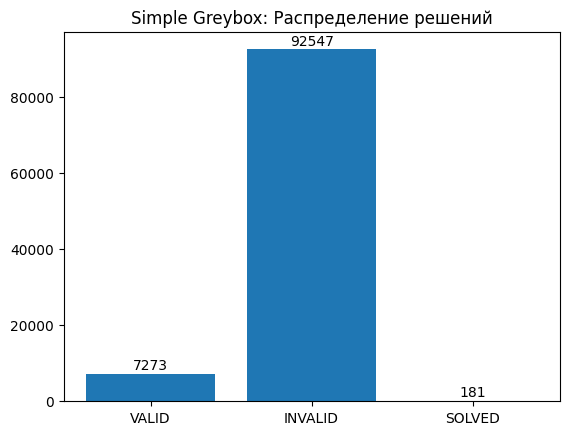

In [34]:
x = list(map(lambda status: status.value, naive_mutation_coverage_fuzzer.stats.keys()))
y = list(naive_mutation_coverage_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Simple Greybox: Распределение решений")
add_bar_labels(x, y, padding=1000)

plt.bar(x, y)
plt.show()

## Boosted Greybox: Power Schedule Mutation Coverage

`Individual` – класс для описания индивида популяции

In [35]:
class Individual:
    def __init__(
        self: Self,
        *,
        data: str,
        coverage: frozenset[int] = set(),
        energy: int = 0
    ) -> None:
        self.data = data
        self.coverage = coverage
        self.energy = energy

    def __hash__(self: Self) -> int:
        return hash(frozenset(self.data))

    def __eq__(self: Self, other: Any) -> bool:
        if not isinstance(other, Individual):
            return NotImplemented
        return self.data == other.data

    def __repr__(self: Self) -> str:
        return f"Individual(data={self.data}, coverage={self.coverage}, energy={self.energy})"

In [36]:
class PowerScheduleMutationCoverageFuzzer(MutationFuzzer):
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set[Individual],
        min_mutations: int,
        max_mutations: int,
        tries: int,
        exponent: float = 1.0
    ) -> None:
        super().__init__(
            target=target,
            seed=seed,
            min_mutations=min_mutations,
            max_mutations=max_mutations,
            tries=tries
        )
        self.exponent = exponent

        self.runner = Runner(target=target)
        self.population = set()
        self.paths_frequency = defaultdict(lambda: 0)

        self.init()

    def mutate(self: Self, individual: Individual) -> Individual:
        turn = randint(1, 3)
        mutation = Mutation(individual=individual.data, initials="DULR")
        match turn:
            case 1:
                mutated_data = mutation.append()
            case 2:
                mutated_data = mutation.delete_last_character()
            case 3:
                mutated_data = mutation.insert()
        return Individual(data=mutated_data)

    def choose(self: Self) -> Individual:
        energies = (individual.energy for individual in self.population)
        return choices(list(self.population), weights=energies)[0]

    @staticmethod
    def energy_distribution(frequency: int, exponent: float) -> float:
        return 1 / pow(frequency, exponent)
    
    def assign_energy(self: Self) -> None:
        for individual in self.population:
            frequency = self.paths_frequency[individual.coverage]
            individual.energy = self.energy_distribution(frequency, self.exponent)

    def create_candidate(self: Self) -> Individual:
        candidate = self.choose()
        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            candidate = self.mutate(candidate)
        return candidate

    def _run(self: Self, individual: Individual) -> SolutionStatus:
        _, result = self.runner.run(individual.data)
        path = frozenset(self.runner.coverage.covered_lines)
        if path in self.paths_frequency:
            self.paths_frequency[path] += 1
        else:
            self.paths_frequency[path] = 1
            self.population.add(Individual(data=individual.data, coverage=path))

        self.stats[result] += 1
        if result is SolutionStatus.SOLVED:
            self.solving_solutions.add(individual.data)

        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        self.assign_energy()
        individual = self.create_candidate()
        result = self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

In [37]:
power_schedule_mutation_coverage_fuzzer = PowerScheduleMutationCoverageFuzzer(
                                                target=maze,
                                                seed={Individual(data="DDU"), Individual(data="DDDL"), Individual(data="U"), Individual(data="L"), Individual(data="R")},
                                                min_mutations=1,
                                                max_mutations=2,
                                                tries=100_000,
                                            )

In [38]:
power_schedule_mutation_coverage_fuzzer.fuzz()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [39]:
power_schedule_mutation_coverage_fuzzer.stats

defaultdict(<function __main__.MutationFuzzer.__init__.<locals>.<lambda>()>,
            {<SolutionStatus.INVALID: 'INVALID'>: 70801,
             <SolutionStatus.VALID: 'VALID'>: 29199,
             <SolutionStatus.SOLVED: 'SOLVED'>: 5})

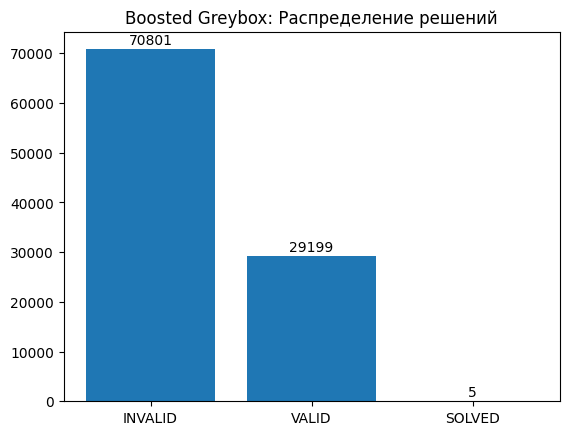

In [40]:
x = list(map(lambda status: status.value, power_schedule_mutation_coverage_fuzzer.stats.keys()))
y = list(power_schedule_mutation_coverage_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Boosted Greybox: Распределение решений")
add_bar_labels(x, y, padding=1000)

plt.bar(x, y)
plt.show()

## Directed Greybox: Directed Power Schedule Mutation

`CallGraphBuilder` – класс для построения графа вызовов функций

In [41]:
class CallGraphBuilder(NodeVisitor):
    def __init__(self: Self) -> None:
        self.call_graph = {}
        self.functions_in_module = set()
        self.current_function = None

    def visit_FunctionDef(self: Self, node: FunctionDef) -> None:
        self.functions_in_module.add(node.name)
        self.current_function = node.name
        self.call_graph[self.current_function] = []
        self.generic_visit(node)
        self.current_function = None

    def visit_Call(self: Self, node: Call) -> None:
        if self.current_function is not None:
            func_name = self._get_func_name(node.func)
            if func_name in self.functions_in_module:
                self.call_graph[self.current_function].append(func_name)
        self.generic_visit(node)

    def _get_func_name(self: Self, node: Any) -> str | None:
        if isinstance(node, Name):
            return node.id
        elif isinstance(node, Attribute):
            return node.attr
        return None

    def build(self: Self, source_code: str) -> dict[str, list[str]]:
        tree = parse(source_code)
        self.visit(tree)
        return self.call_graph

__Пример__

In [42]:
builder = CallGraphBuilder()

In [43]:
source = "".join(getsourcelines(getmodule(maze))[0])
call_graph = builder.build(source)

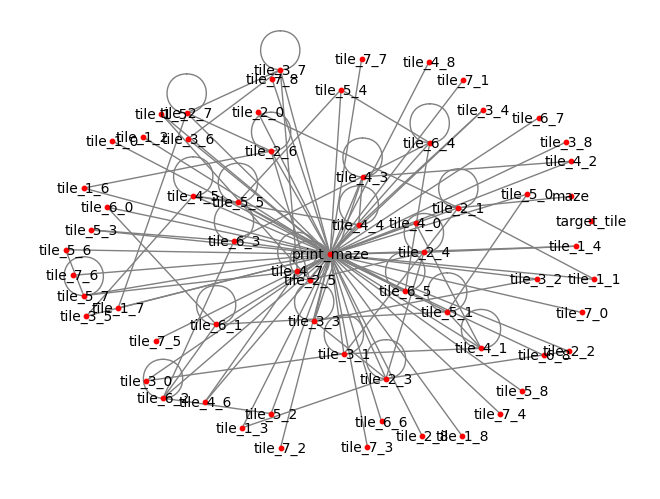

In [44]:
graph = nx.Graph(call_graph)
position = nx.spring_layout(graph, k=1, iterations=50)
nx.draw(graph, position, with_labels=True, node_color="red", node_size=10, font_size=10, edge_color="gray")
plt.show()

`CallTracker` – класс для отслеживания вызовов функций

In [45]:
class CallTacker(Tracker):
    def __init__(self: Self, *, function: Callable[..., Any]) -> None:
        self.function = function

        self.functions = {function[0] for function in getmembers(getmodule(self.function), isfunction)}
        self.called_functions = set()
        self.tracer = Tracer()

    def reset(self: Self) -> None:
        self.called_functions.clear()

    def run_with_args(self: Self, *args, **kwargs) -> Any:
        self.reset()
        result = self.tracer.trace(self.function, *args, **kwargs)
        self.called_functions = self.tracer.called_functions
        return result

In [46]:
class Runner:
    def __init__(self: Self, *, target: Callable[..., Any]) -> None:
        self.target = target
        self.calls = CallTacker(function=self.target)

    def run_function(self: Self, *args, **kwargs) -> Any:
        return self.target(*args, **kwargs)

    def run_calls(self: Self, *args, **kwargs) -> Any:
        return self.calls.run_with_args(*args, **kwargs)

    def run(self: Self, *args, **kwargs) -> tuple[Any, SolutionStatus]:
        result = self.run_calls(*args, **kwargs)
        return result, get_solution_status(result)

In [47]:
class Individual:
    def __init__(
        self: Self,
        *,
        data: str,
        calls: frozenset[str] = set(),
        distance: float = float("-inf"),
        energy: float = 0
    ) -> None:
        self.data = data
        self.calls = calls
        self.distance = distance
        self.energy = energy

    def __hash__(self: Self) -> int:
        return hash(frozenset(self.data))

    def __eq__(self: Self, other: Any) -> bool:
        if not isinstance(other, Individual):
            return NotImplemented
        return self.data == other.data

    def __repr__(self: Self) -> str:
        return f"Individual(data={self.data}, calls={self.calls}, distance={self.distance}, energy={self.energy})"

In [48]:
class DirectedFuzzer(MutationFuzzer):
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        goal: str,
        seed: set[Individual],
        min_mutations: int,
        max_mutations: int,
        tries: int,
        exponent: float = 1.0
    ) -> None:
        super().__init__(
            target=target,
            seed=seed,
            min_mutations=min_mutations,
            max_mutations=max_mutations,
            tries=tries
        )
        self.exponent = exponent

        self.runner = Runner(target=target)
        self.population = set()
        self.called_functions_status = {function: False for function in self.runner.calls.functions}

        # Build call graph and calculate distances
        builder = CallGraphBuilder()
        source = "".join(getsourcelines(getmodule(maze))[0])
        adjacency_list = builder.build(source)
        graph = nx.Graph(adjacency_list)
        self.distances = dict(nx.shortest_path_length(graph, source=goal))

        self.init()

    def mutate(self: Self, individual: Individual) -> Individual:
        turn = randint(1, 3)
        mutation = Mutation(individual=individual.data, initials="DULR")
        match turn:
            case 1:
                mutated_data = mutation.append()
            case 2:
                mutated_data = mutation.delete_last_character()
            case 3:
                mutated_data = mutation.insert()
        return Individual(data=mutated_data)

    def choose(self: Self) -> Individual:
        energies = [individual.energy for individual in self.population]
        return choices(list(self.population), weights=energies)[0]

    @staticmethod
    def energy_distribution(frequency: int, exponent: float) -> float:
        return 1 / pow(frequency, exponent)

    def assign_energy(self: Self) -> None:
        for individual in self.population:
            if individual.distance < 0:
                individual_distances = [self.distances[function] for function in individual.calls if function in self.distances]
                if individual_distances:
                    individual.distance = mean(individual_distances)
                    individual.energy = self.energy_distribution(individual.distance, self.exponent)

    def create_candidate(self: Self) -> Individual:
        candidate = self.choose()
        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            candidate = self.mutate(candidate)
        return candidate

    def _run(self: Self, individual: Individual) -> SolutionStatus:
        _, result = self.runner.run(individual.data)
        called_functions = self.runner.calls.called_functions
        for function in called_functions:
            if function in self.called_functions_status and not self.called_functions_status[function]:
                self.called_functions_status[function] = True
                individual.calls = {function for function in called_functions if function in self.called_functions_status}
                self.population.add(individual)

        self.stats[result] += 1
        if result is SolutionStatus.SOLVED:
            self.solving_solutions.add(individual)

        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        self.assign_energy()
        individual = self.create_candidate()
        result = self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

In [73]:
directed_fuzzer = DirectedFuzzer(
                        target=maze,
                        goal="tile_6_7",
                        seed={Individual(data="DD"), Individual(data="U"), Individual(data="L"), Individual(data="R")},
                        min_mutations=1,
                        max_mutations=3,
                        tries=30_000,
                    )

In [74]:
directed_fuzzer.fuzz()

  0%|          | 0/30000 [00:00<?, ?it/s]

In [75]:
directed_fuzzer.stats

defaultdict(<function __main__.MutationFuzzer.__init__.<locals>.<lambda>()>,
            {<SolutionStatus.INVALID: 'INVALID'>: 26470,
             <SolutionStatus.VALID: 'VALID'>: 3310,
             <SolutionStatus.SOLVED: 'SOLVED'>: 224})

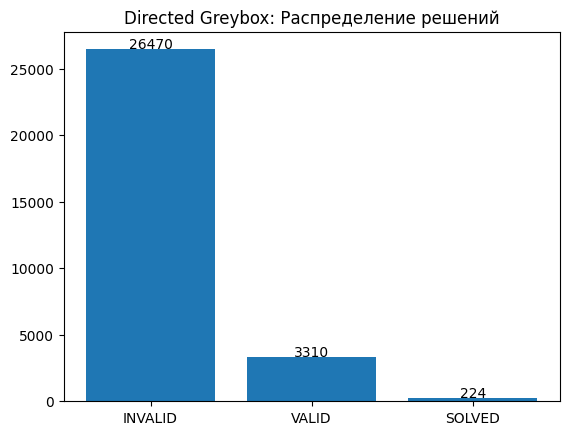

In [76]:
x = list(map(lambda status: status.value, directed_fuzzer.stats.keys()))
y = list(directed_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Directed Greybox: Распределение решений")
add_bar_labels(x, y, padding=80)

plt.bar(x, y)
plt.show()

## Advanced Directed Greybox: Advanced Directed Power Schedule Mutation

In [77]:
class AdvancedDirectedFuzzer(DirectedFuzzer):
    def assign_energy(self: Self) -> None:
        min_dist = maxsize
        max_dist = 0
        for individual in self.population:
            if individual.distance < 0:
                individual_distances = [self.distances[function] for function in individual.calls if function in self.distances]
                if individual_distances:
                    individual.distance = mean(individual_distances)

                if individual.distance < min_dist:
                    min_dist = individual.distance
                
                if individual.distance > max_dist:
                    max_dist = individual.distance

        for individual in self.population:
            if individual.distance == min_dist:
                if min_dist == max_dist:
                    individual.energy = 1
                else:
                    individual.energy = max_dist - min_dist
            else:
                individual.energy = (max_dist - min_dist) / (individual.distance - min_dist)

__Расчёты__

In [78]:
advanced_directed_fuzzer = AdvancedDirectedFuzzer(
                        target=maze,
                        goal="tile_6_7",
                        seed={Individual(data="DD"), Individual(data="U"), Individual(data="L"), Individual(data="R")},
                        min_mutations=1,
                        max_mutations=3,
                        tries=30_000,
                    )

In [79]:
advanced_directed_fuzzer.fuzz()

  0%|          | 0/30000 [00:00<?, ?it/s]

In [80]:
advanced_directed_fuzzer.stats

defaultdict(<function __main__.MutationFuzzer.__init__.<locals>.<lambda>()>,
            {<SolutionStatus.INVALID: 'INVALID'>: 24936,
             <SolutionStatus.VALID: 'VALID'>: 4801,
             <SolutionStatus.SOLVED: 'SOLVED'>: 267})

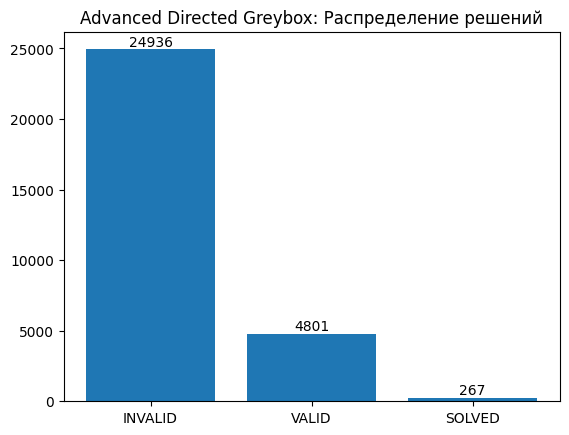

In [81]:
x = list(map(lambda status: status.value, advanced_directed_fuzzer.stats.keys()))
y = list(advanced_directed_fuzzer.stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Advanced Directed Greybox: Распределение решений")
add_bar_labels(x, y, padding=200)

plt.bar(x, y)
plt.show()